## **Multi-Class Imbalanced Classification**
___
- Handle imbalanced classes

### **SMOTE Oversampling**
- <a href='https://arxiv.org/abs/1106.1813'> Literature </a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## **Path and directory**
___

In [2]:
CURRENT_DIR = "/content/gdrive/My Drive/code/ingredient_prediction/code"
DATA_DIR = "/content/gdrive/My Drive/code/ingredient_prediction/data"
FTR_PATH = "/content/gdrive/My Drive/code/ingredient_prediction/data/recipes_input.csv"
LBL_PATH = "/content/gdrive/My Drive/code/ingredient_prediction/data/recipes_output.csv"

## **Libraries**
___

In [3]:
!cp "/content/gdrive/My Drive/code/ingredient_prediction/code/util.py" .

!pip install -qq factor-analyzer

In [3]:
# import imbalanced-learn library that provides SMOTE implementation
# Note: does not work very well
import imblearn
print(imblearn.__version__)

0.4.3


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
import util
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler
from tensorflow.keras.utils import plot_model
# from tensorflow.keras.optimizers.schedules import ExponentialDecay

from tensorflow import feature_column


## **Read data feature and label**
___

In [5]:
ftr_df = pd.read_csv(FTR_PATH, skipinitialspace=True)
lbl_df = pd.read_csv(LBL_PATH, skipinitialspace=True)

In [6]:
print("Shape of feature dataframe: ",ftr_df.shape)
print("Shape of label dataframe: ", lbl_df.shape)

print("==================== View of Feature Dataframe ====================")
print(ftr_df.head(10))

print("==================== View of Label Dataframe ====================")
print(lbl_df.head(10))

Shape of feature dataframe:  (84119, 584)
Shape of label dataframe:  (84119, 584)
==================== View of Feature Dataframe ====================
   Unnamed: 0  0  1  2  3  4  5  6  ...  575  576  577  578  579  580  581  582
0           0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0
1           1  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0
2           2  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0
3           3  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0
4           4  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0
5           5  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0
6           6  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0
7           7  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0
8           8  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0
9           9  0  0  0  0  0  0  0  ...    0    0 

In [7]:
## Drop the first index columns 
ftr_df.drop(columns=['Unnamed: 0'], inplace=True)
lbl_df.drop(columns=['Unnamed: 0'], inplace=True)

In [8]:
# Check for null cells
print("Checking for null or nan cells in feature and label dataframes....")
print("==================== Feature Dataframe ====================")
print("Null: ", ftr_df.isnull().values.any())
print("NaN: ", ftr_df.isna().values.any())
print("==================== Label Dataframe ====================")
print("Null: ", lbl_df.isnull().values.any())
print("NaN: ", lbl_df.isna().values.any())

Checking for null or nan cells in feature and label dataframes....
==================== Feature Dataframe ====================
Null:  False
NaN:  False
==================== Label Dataframe ====================
Null:  False
NaN:  False


## **Convert one-hot encoded output to categorical output**
___

In [9]:
# convert label dataframe to numpy array
lbl = np.asarray(lbl_df)
print("Checking dimension of label array: ", lbl.shape)

Checking dimension of label array:  (84119, 583)


In [10]:
# getting column number of each row where the entry is 1
lbl_arr = np.argwhere(lbl==1)[:,1]

In [11]:
print("Checking dimension of the categorical label array.....")
print("Dimension of categorical label array: ", lbl_arr.shape)

Checking dimension of the categorical label array.....
Dimension of categorical label array:  (84119,)


In [12]:
print("Total of unique categories in the label: ", len(np.unique(lbl_arr)))

Total of unique categories in the label:  583


## **Study the frequency count of all label classes**
___

In [13]:
# get array of unique classes and respective frequencies
(unique_class, class_freq) = np.unique(lbl_arr, return_counts=True)

# construct dictionary that maps frequency to each class label
# freq_dict = {class_label : freq for class_label, freq in zip(unique_class, class_freq)}

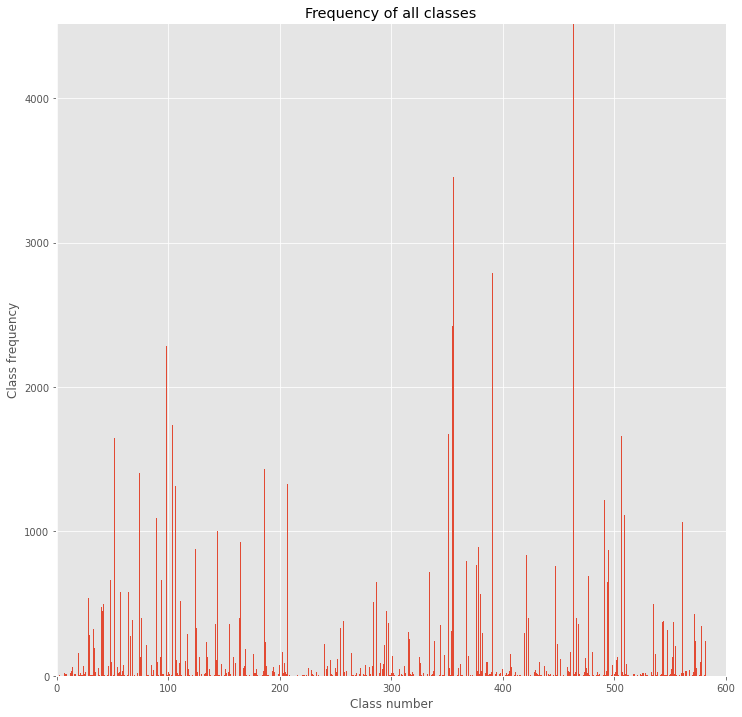

In [14]:
# plot the histogram
plt.style.use('ggplot')
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.bar(unique_class, class_freq, width=0.8, align='center')
ax.set_xlim([-0.5, 600])
ax.set_ylim([0, np.max(class_freq)+1])
ax.set_xlabel('Class number')
ax.set_ylabel('Class frequency')
plt.title('Frequency of all classes')
plt.show()
plt.style.use('default')


## **Oversample with SMOTE**
___
- Default strategy: oversample each class to have the same number of examples as the class with the most examples.

In [15]:
total_class = len(unique_class)
max_freq = np.max(class_freq)
print("Maximum class frequency is: ", max_freq)
print("Total number of unique classes: ", total_class)

Maximum class frequency is:  4518
Total number of unique classes:  583


In [21]:
sample_size = 1000
resampled_ftr = np.zeros((sample_size*total_class, total_class))
resampled_lbl = np.zeros((sample_size*total_class, total_class))
k = 0
for class_lbl, freq in zip(unique_class, class_freq):
  # print("#########################################")
  # print("Unique class label: ", class_lbl)
  # print("Class frequency: ", freq)
  ids = np.arange(freq)
  choices = np.random.choice(ids, sample_size)

  current_class_ftr = ftr_df[lbl_arr==class_lbl].values
  current_class_lbl = lbl_df[lbl_arr==class_lbl].values

  oversampled_class_ftr = current_class_ftr[choices]
  oversampled_class_lbl = current_class_lbl[choices]

  resampled_ftr[k*sample_size:(k+1)*sample_size, :] = oversampled_class_ftr
  resampled_lbl[k*sample_size:(k+1)*sample_size, :] = oversampled_class_lbl

  k += 1

print("Shape of resampled feature arrays: ", resampled_ftr.shape)
print("Shape of resampled label arrays: ", resampled_lbl.shape)

Shape of resampled feature arrays:  (583000, 583)
Shape of resampled label arrays:  (583000, 583)


In [23]:
# reshuffle the resampled data
order = np.arange(sample_size*total_class)
np.random.shuffle(order)
resampled_ftr = resampled_ftr[order]
resampled_lbl = resampled_lbl[order]

# check the shape of the resampled data
print("Shape of the re-sampled feature array: ", resampled_ftr.shape)
print("Shape of the re-sampled labal array: ", resampled_lbl.shape)

Shape of the re-sampled feature array:  (583000, 583)
Shape of the re-sampled labal array:  (583000, 583)


## **Train-validation-test split**
___

In [1]:
ftrTr, ftrTs, lblTr, lblTs = train_test_split(resampled_ftr, resampled_lbl, test_size=0.2, random_state=42)
ftrTr, ftrVal, lblTr, lblVal = train_test_split(ftrTr, lblTr, test_size=0.2, random_state=42)

NameError: ignored

In [ ]:
print(len(ftrTr), 'training samples')
print(len(ftrVal), 'validation samples')
print(len(ftrTs), 'test samples')

53836 training samples
13459 validation samples
16824 test samples


## **Input parameters**
___

In [ ]:
batch_size = 32
num_classes = len(ftrTr.columns)
print("Batch size: ", batch_size)
print("Total number of classes: ", num_classes)

Batch size:  32
Total number of classes:  583


## **Define the model**
___

In [ ]:
modelName = 'codefull_2'

# define learning scheduler
# lr_schedule = ExponentialDecay(initial_learning_rate=0.1,
#                                decay_steps=100000,
#                                decay_rate=0.96,
#                                staircase=True
# )

optmz = optimizers.Adam()

def createModel():
  input = Input(shape=(num_classes,))
  x = Dense(640, activation='relu', kernel_initializer='he_normal',
            kernel_regularizer=l2(1e-4))(input)
  x = Dropout(0.25)(x)
  x = Dense(800, activation='relu', kernel_initializer='he_normal',
            kernel_regularizer=l2(1e-4))(x)
  x = Dropout(0.25)(x)
  x = Dense(960, activation='relu', kernel_initializer='he_normal',
            kernel_regularizer=l2(1e-4))(x)
  x = Dropout(0.5)(x)
  output = Dense(num_classes, kernel_initializer='he_normal', activation='softmax')(x)

  model = Model(inputs=input, outputs = output)
  model.compile(loss='categorical_crossentropy',
                optimizer = optmz,
                metrics=['accuracy'])
  
  return model

In [ ]:
model = createModel()
model.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 583)]             0         
_________________________________________________________________
dense_24 (Dense)             (None, 640)               373760    
_________________________________________________________________
dropout_18 (Dropout)         (None, 640)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 800)               512800    
_________________________________________________________________
dropout_19 (Dropout)         (None, 800)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 960)               768960    
_________________________________________________________________
dropout_20 (Dropout)         (None, 960)             

## **Create training checkpoints**
___

In [ ]:
# define model filepath
filepath = CURRENT_DIR + modelName + '.hdf5'
logpath = CURRENT_DIR + modelName + '.csv'
print("Path to hdf5 model file: ", filepath)
print("Path to logging csv file: ", logpath)

# define checkpoint
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',
                             verbose=0,
                             save_best_only=True,
                             mode='max')

# define logging information
csv_logger = CSVLogger(logpath)

# define learning rate scheduler
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
lr_scheduler = LearningRateScheduler(scheduler)

# define callback list
callback_list = [checkpoint, csv_logger, lr_scheduler ]


Path to hdf5 model file:  /content/gdrive/My Drive/code/ingredient_prediction/codecodefull_2.hdf5
Path to logging csv file:  /content/gdrive/My Drive/code/ingredient_prediction/codecodefull_2.csv


## **Train the neural network**
___

In [ ]:
model.fit(ftrTr, lblTr,
          validation_data=(ftrVal, lblVal),
          epochs=100,
          batch_size=batch_size,
          shuffle=True,
          callbacks=callback_list)

Epoch 1/100
1683/1683 [==============================] - 6s 4ms/step - loss: 4.5534 - accuracy: 0.1775 - val_loss: 4.1093 - val_accuracy: 0.2424
Epoch 2/100
1683/1683 [==============================] - 6s 3ms/step - loss: 4.0192 - accuracy: 0.2518 - val_loss: 3.8547 - val_accuracy: 0.2860
Epoch 3/100
1683/1683 [==============================] - 6s 3ms/step - loss: 3.7453 - accuracy: 0.3006 - val_loss: 3.6989 - val_accuracy: 0.3229
Epoch 4/100
1683/1683 [==============================] - 6s 3ms/step - loss: 3.5393 - accuracy: 0.3452 - val_loss: 3.5727 - val_accuracy: 0.3542
Epoch 5/100
1683/1683 [==============================] - 6s 3ms/step - loss: 3.3747 - accuracy: 0.3786 - val_loss: 3.4922 - val_accuracy: 0.3788
Epoch 6/100
1683/1683 [==============================] - 6s 3ms/step - loss: 3.2341 - accuracy: 0.4066 - val_loss: 3.4233 - val_accuracy: 0.3991
Epoch 7/100
1683/1683 [==============================] - 6s 3ms/step - loss: 3.1197 - accuracy: 0.4366 - val_loss: 3.3705 - val_ac

## **Validate the neural network**
___

In [ ]:
modelTest = createModel()
modelTest.load_weights(filepath)
modelTest.compile(loss='categorical_crossentropy',
                  optimizer=optmz,
                  metrics=['accuracy'])
prediction = modelTest.predict(ftrTs)
print("Prediction completes.")

Prediction completes.


## **Report classification metrics**
___

In [ ]:
predout = np.argmax(prediction, axis=1)
testout = np.argmax(np.asarray(lblTs), axis=1)
testScores = metrics.accuracy_score(testout, predout)

print("Accuracy on test set based on the best training model: %.2f%%" % (testScores*100) )

Accuracy on test set based on the best training model: 60.65%


In [ ]:
print(metrics.classification_report(testout, predout, digits=4))

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         5
           2     0.0000    0.0000    0.0000         2
           6     0.0000    0.0000    0.0000         1
           7     0.0000    0.0000    0.0000         3
           8     0.0000    0.0000    0.0000         2
           9     0.0000    0.0000    0.0000         2
          11     0.0000    0.0000    0.0000         1
          12     0.2000    0.2000    0.2000         5
          13     0.0000    0.0000    0.0000         9
          14     0.0769    0.0714    0.0741        14
          16     0.0000    0.0000    0.0000         2
          17     0.5000    0.3333    0.4000         3
          18     0.0000    0.0000    0.0000         1
          19     0.2143    0.1818    0.1967        33
          20     0.0000    0.0000    0.0000         2
          21     0.0000    0.0000    0.0000         4
          22     0.0000    0.0000    0.0000         3
          23     0.0000    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **Confusion matrix**
___

In [ ]:
confusion = metrics.confusion_matrix(testout, predout)
confusion_df = pd.DataFrame(confusion)
print(confusion_df)

     0    1    2    3    4    5    6    ...  447  448  449  450  451  452  453
0      0    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
1      0    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
2      0    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
3      0    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
4      0    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
449    0    0    0    0    0    0    0  ...    0    0    9    0    0    0    0
450    0    0    0    0    0    0    0  ...    0    0    0   23    0    0    0
451    0    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
452    0    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
453    0    0    0    0    0    0    0  ...    0    0    0    0    0    0   13

[454 rows x 454 columns]


## **Plot validation loss and and accuracy while training**
___

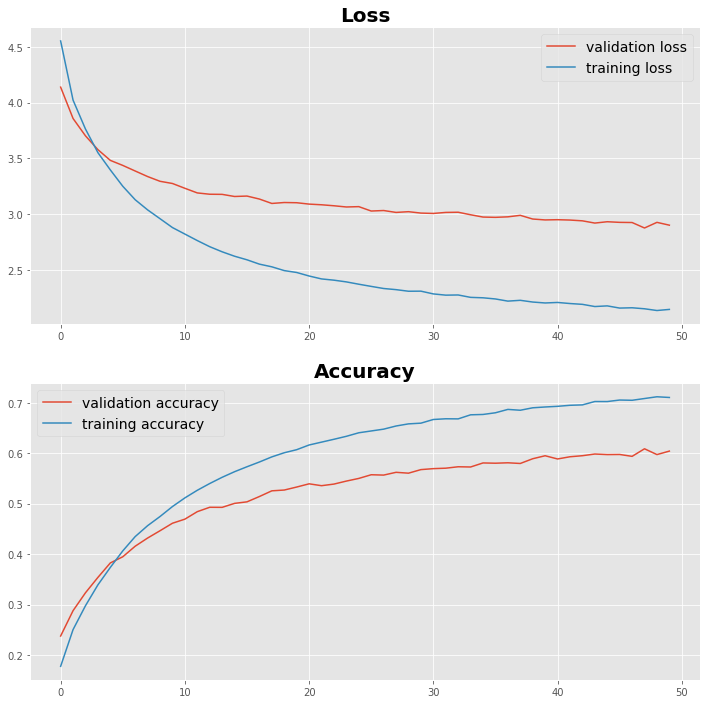

In [ ]:
records = pd.read_csv(logpath)
plt.style.use('ggplot')
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
ax1.plot(records['val_loss'], label='validation loss')
ax1.plot(records['loss'], label='training loss')
ax1.set_title("Loss", fontsize=20, weight='bold')
ax1.legend(fontsize=14)

ax2 = fig.add_subplot(212)
ax2.plot(records['val_accuracy'], label='validation accuracy')
ax2.plot(records['accuracy'], label='training accuracy')
ax2.set_title("Accuracy", fontsize=20, weight='bold')
ax2.legend(fontsize=14)

plt.show()

## **Save the model plot**
___

In [ ]:
plotpath = CURRENT_DIR + modelName + '_plot.png'
plot_model(model, to_file=plotpath, show_shapes=True, show_layer_names=True,
           rankdir='TB', expand_nested=True)
print("Path to model plot: ", plotpath)

Path to model plot:  /content/gdrive/My Drive/code/ingredient_prediction/codefull_plot.png
